## Car Selling Price Prediction


In [1]:
#installing necessary libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor 
import xgboost as xgb
import lightgbm as lgb
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## Data Collection and Preprocessing
car_dataset = pd.read_csv('car.csv')
car_dataset.describe()

,year,selling_price,km_driven,mileage(km/ltr/kg),engine,seats
count,8128.000000,8.128000e+03,8.128000e+03,7907.000000,7907.000000,7907.000000
mean,2013.804011,6.382718e+05,6.981951e+04,19.418783,1458.625016,5.416719
std,4.044249,8.062534e+05,5.655055e+04,4.037145,503.916303,0.959588
min,1983.000000,2.999900e+04,1.000000e+00,0.000000,624.000000,2.000000
25%,2011.000000,2.549990e+05,3.500000e+04,16.780000,1197.000000,5.000000
50%,2015.000000,4.500000e+05,6.000000e+04,19.300000,1248.000000,5.000000
75%,2017.000000,6.750000e+05,9.800000e+04,22.320000,1582.000000,5.000000
max,2020.000000,1.000000e+07,2.360457e+06,42.000000,3604.000000,14.000000


(8128, 12)


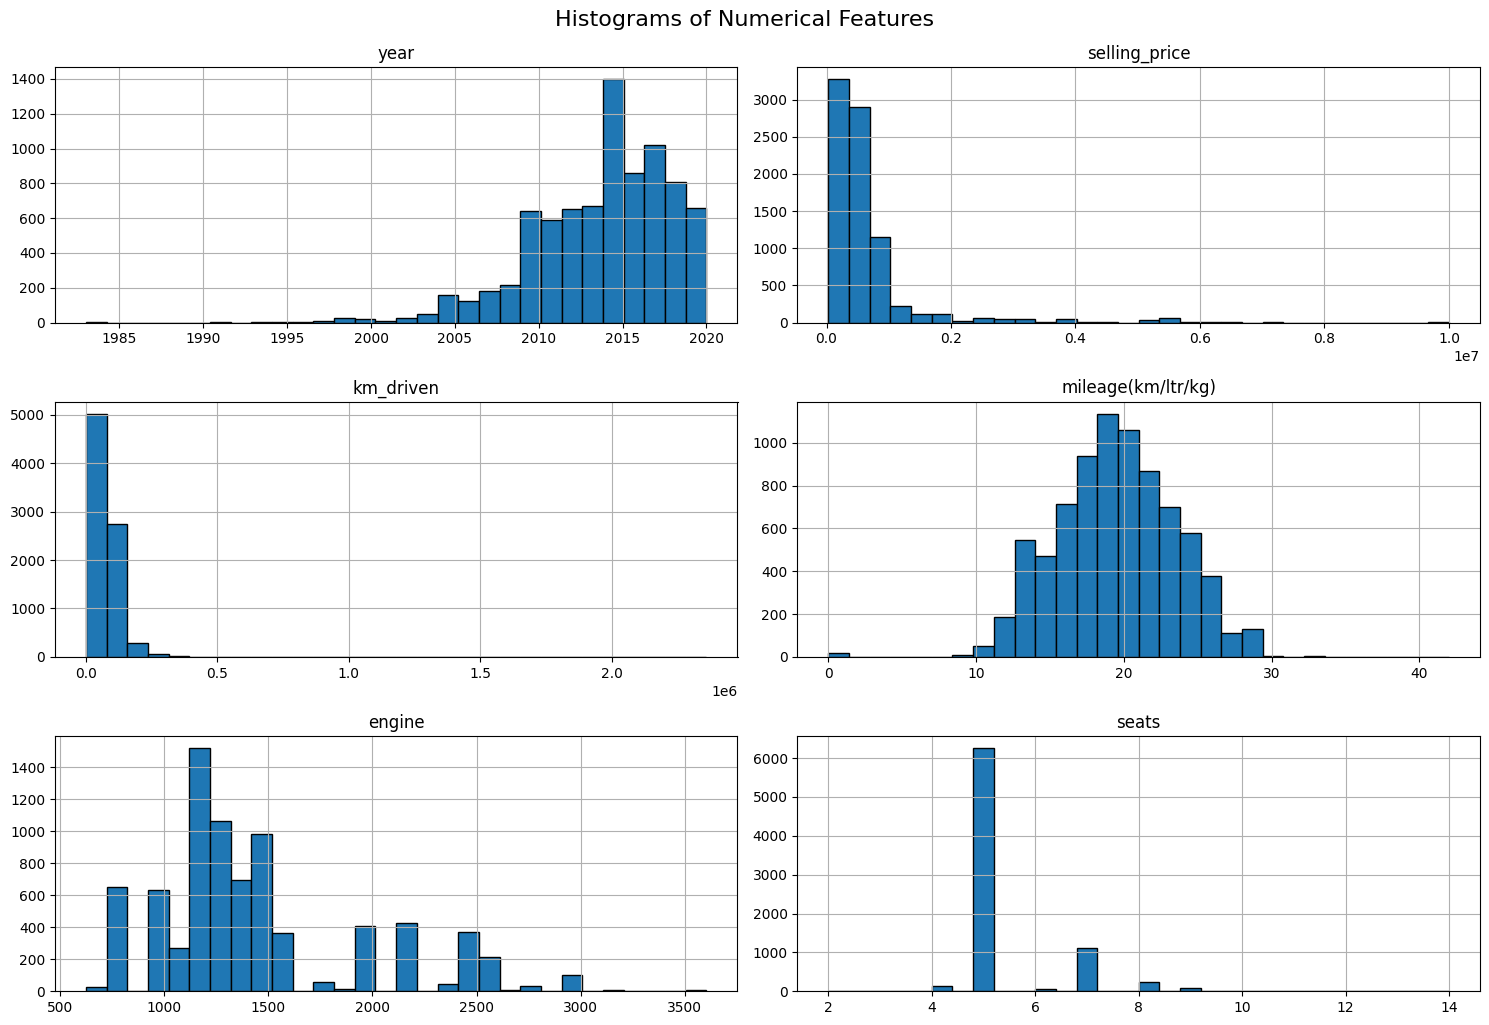

In [3]:
# Inspecting the dataset
print(car_dataset.shape)
import matplotlib.pyplot as plt

# Select only numerical columns
numeric_cols = car_dataset.select_dtypes(include=['int64', 'float64']).columns

# Plot histogram for each numerical column
car_dataset[numeric_cols].hist(bins=30, figsize=(15, 10), edgecolor='black')
plt.tight_layout()
plt.suptitle('Histograms of Numerical Features', fontsize=16, y=1.02)
plt.show()


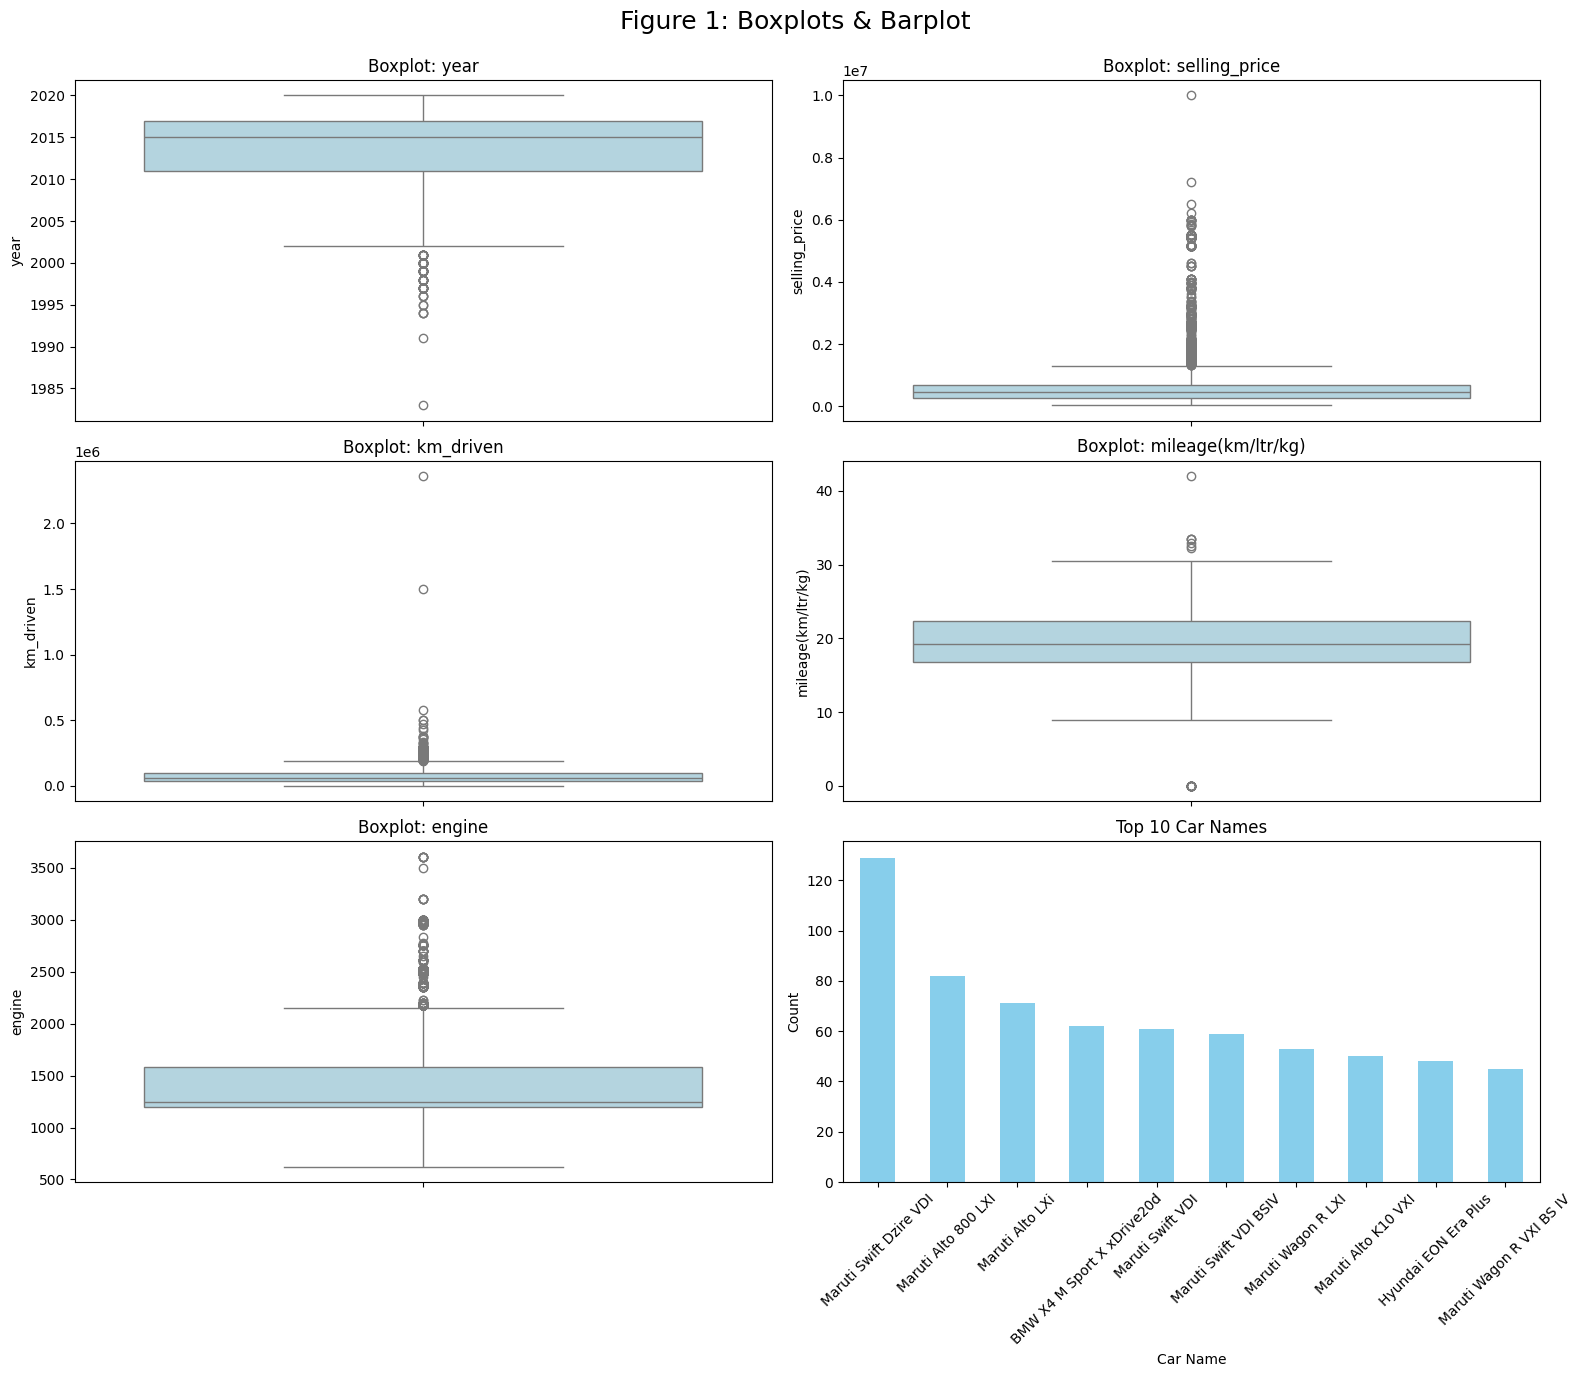

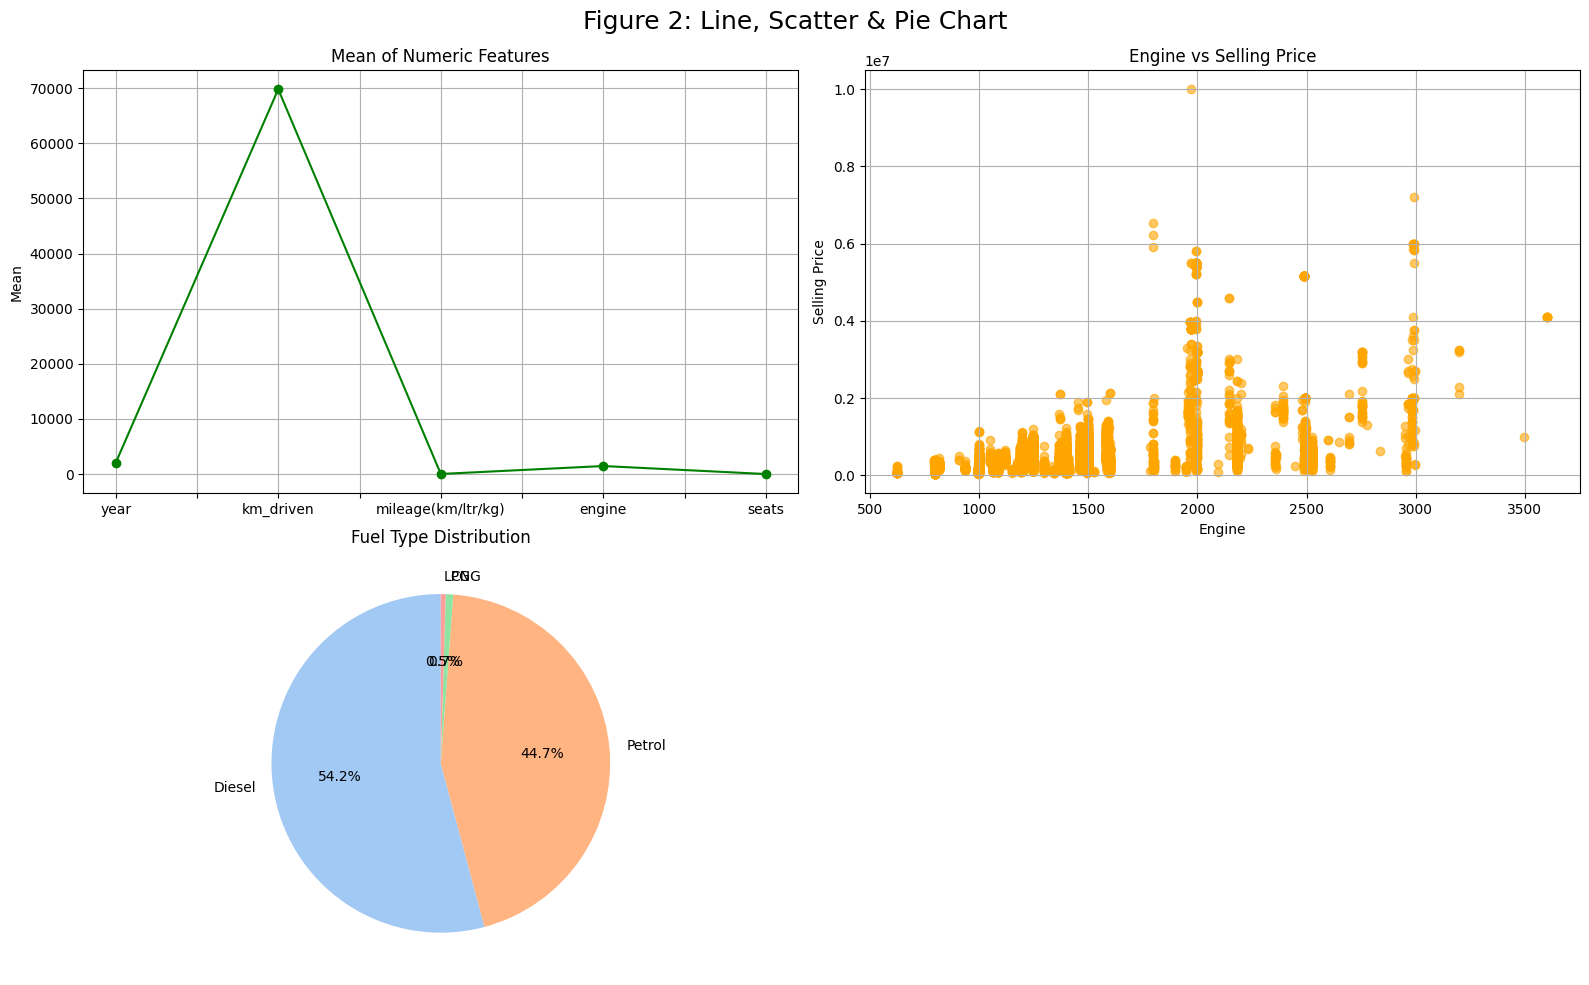

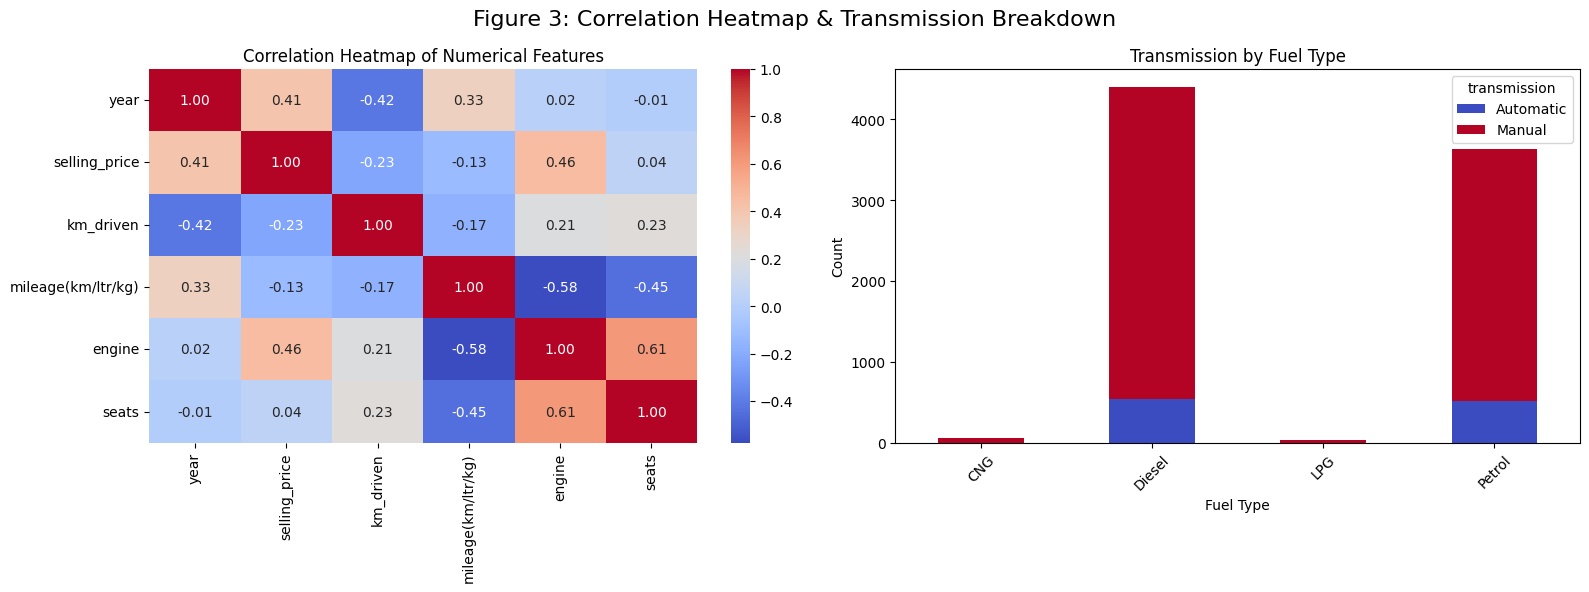

In [4]:
# Dataset Visualization
# ---------------- Figure 1: Boxplots and Barplot ----------------
fig1, axes1 = plt.subplots(3, 2, figsize=(16, 14))
axes1 = axes1.flatten()

# Boxplots
for i, col in enumerate(numeric_cols[:5]):
    sns.boxplot(data=car_dataset, y=col, ax=axes1[i], color='lightblue')
    axes1[i].set_title(f'Boxplot: {col}')
    axes1[i].set_xlabel('')

# Barplot: Top 10 car names
top_names = car_dataset['name'].value_counts().head(10)
top_names.plot(kind='bar', ax=axes1[5], color='skyblue')
axes1[5].set_title('Top 10 Car Names')
axes1[5].set_xlabel('Car Name')
axes1[5].set_ylabel('Count')
axes1[5].tick_params(axis='x', rotation=45)

fig1.tight_layout()
fig1.suptitle("Figure 1: Boxplots & Barplot", fontsize=18)
fig1.subplots_adjust(top=0.93)
plt.show()

# ---------------- Figure 2: 4 Subplots ----------------
fig2, axes2 = plt.subplots(2, 2, figsize=(16, 10))

# Line Plot: Mean of numeric columns
num_cols = car_dataset.select_dtypes(include=['int64', 'float64']).columns
num_cols = num_cols.drop('selling_price', errors='ignore')  # Exclude target variable if present
car_dataset[num_cols].mean().plot(marker='o', ax=axes2[0, 0], color='green')
axes2[0, 0].set_title('Mean of Numeric Features')
axes2[0, 0].set_ylabel('Mean')
axes2[0, 0].grid(True)

# Scatter Plot: Engine vs Selling Price
axes2[0, 1].scatter(car_dataset['engine'], car_dataset['selling_price'], alpha=0.6, color='orange')
axes2[0, 1].set_title('Engine vs Selling Price')
axes2[0, 1].set_xlabel('Engine')
axes2[0, 1].set_ylabel('Selling Price')
axes2[0, 1].grid(True)

# Pie Chart: Fuel Type
car_dataset['fuel'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, ax=axes2[1, 0], colors=sns.color_palette('pastel'))
axes2[1, 0].set_title('Fuel Type Distribution')
axes2[1, 0].set_ylabel('')

# Empty bottom-right plot (for aesthetics)
axes2[1, 1].axis('off')

fig2.tight_layout()
fig2.suptitle("Figure 2: Line, Scatter & Pie Chart", fontsize=18)
fig2.subplots_adjust(top=0.92)
plt.show()

# Create subplots: 1 row, 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# ---------------- Left Plot: Correlation Heatmap ----------------
sns.heatmap(car_dataset[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f", ax=ax1)
ax1.set_title('Correlation Heatmap of Numerical Features')

# ---------------- Right Plot: Stacked Bar Chart ----------------
if 'fuel' in car_dataset.columns and 'transmission' in car_dataset.columns:
    crosstab_data = pd.crosstab(car_dataset['fuel'], car_dataset['transmission'])
    crosstab_data.plot(kind='bar', stacked=True, colormap='coolwarm', ax=ax2)
    ax2.set_title('Transmission by Fuel Type')
    ax2.set_xlabel('Fuel Type')
    ax2.set_ylabel('Count')
    ax2.tick_params(axis='x', rotation=45)

# Final layout tweaks
fig.tight_layout()
fig.suptitle("Figure 3: Correlation Heatmap & Transmission Breakdown", fontsize=16)
fig.subplots_adjust(top=0.88)
plt.show()

In [5]:
# Make a copy to work safely
df = car_dataset.copy()

# 1. Car Age (Assuming current year is 2025)
df['car_age'] = 2025 - df['year']

# 2. Price per KM (avoid division by zero)
df['price_per_km'] = df['selling_price'] / (df['km_driven'] + 1)

# 3. Engine per Seat (avoid division by zero and NaNs)
df['engine_per_seat'] = df['engine'] / (df['seats'].replace(0, np.nan))

# Drop any rows with inf or NaN created
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['price_per_km', 'engine_per_seat'])

# Show new features
print(df[['car_age', 'price_per_km', 'engine_per_seat']].describe())

           car_age   price_per_km  engine_per_seat
count  7907.000000    7907.000000      7907.000000
mean     11.017832      46.405994       267.916655
std       3.866650    1180.252747        74.632703
min       5.000000       0.184501        99.500000
25%       8.000000       3.288646       224.000000
50%      10.000000       7.299927       249.600000
75%      13.000000      18.434823       299.600000
max      31.000000  104500.000000      1261.500000


In [6]:
# Step 1: Concatenate new features from df to car_dataset
car_dataset = pd.concat([car_dataset, df[['car_age', 'price_per_km', 'engine_per_seat']]], axis=1)

# Step 2: Drop the raw columns if they exist
car_dataset.drop(columns=['year'], inplace=True, errors='ignore')

# Step 3: Check the result
print(car_dataset.shape)
print(car_dataset.head())

(8128, 14)
                           name  selling_price  km_driven    fuel seller_type  \
0        Maruti Swift Dzire VDI         450000     145500  Diesel  Individual   
1  Skoda Rapid 1.5 TDI Ambition         370000     120000  Diesel  Individual   
2      Honda City 2017-2020 EXi         158000     140000  Petrol  Individual   
3     Hyundai i20 Sportz Diesel         225000     127000  Diesel  Individual   
4        Maruti Swift VXI BSIII         130000     120000  Petrol  Individual   

  transmission         owner  mileage(km/ltr/kg)  engine max_power  seats  \
0       Manual   First Owner               23.40  1248.0        74    5.0   
1       Manual  Second Owner               21.14  1498.0    103.52    5.0   
2       Manual   Third Owner               17.70  1497.0        78    5.0   
3       Manual   First Owner               23.00  1396.0        90    5.0   
4       Manual   First Owner               16.10  1298.0      88.2    5.0   

   car_age  price_per_km  engine_per_se

Text(0.5, 1.0, 'Correlation Heatmap of Numerical Features')

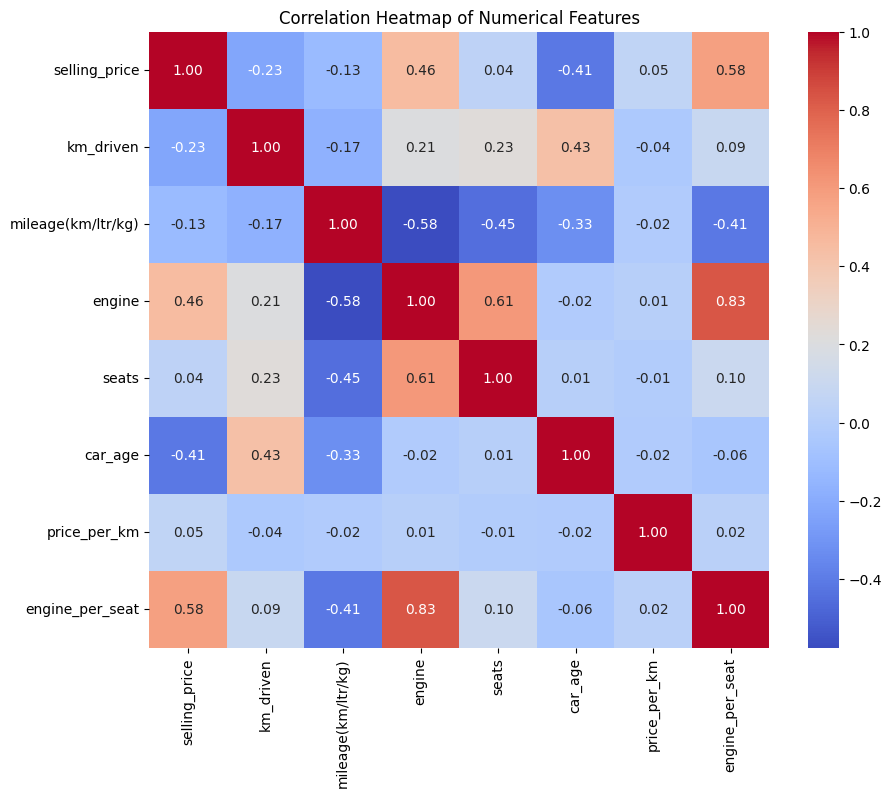

In [7]:
# Visualizing the correlation heatmap of numerical features after feature engineering
num_cols = car_dataset.select_dtypes(include=['int64', 'float64']).columns
fig, ax1 = plt.subplots(figsize=(10, 8))
sns.heatmap(car_dataset[num_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f", ax=ax1)
ax1.set_title('Correlation Heatmap of Numerical Features')

Null rows in car_dataset

name                  0
selling_price         0
km_driven             0
fuel                  0
seller_type           0
transmission          0
owner                 0
mileage(km/ltr/kg)    0
engine                0
max_power             0
seats                 0
car_age               0
price_per_km          0
engine_per_seat       0
Duplicate Rows in car_dataset: 0


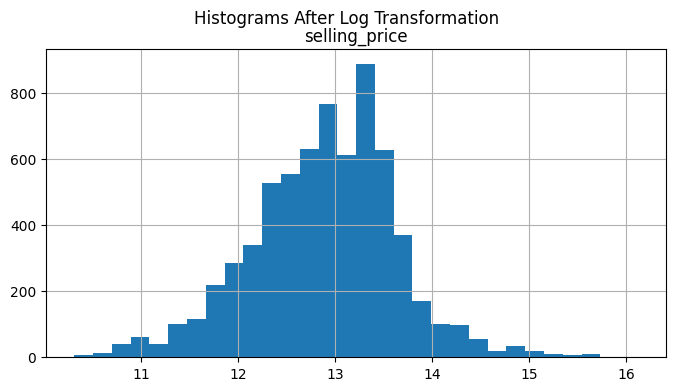

In [8]:
# Step 1: Clean the dataset
car_dataset = car_dataset.dropna()
car_dataset = car_dataset.drop_duplicates()

print("Null rows in car_dataset\n")
print(car_dataset.isnull().sum().to_string())

print("Duplicate Rows in car_dataset:", car_dataset.duplicated().sum())

# Step 2: Log-transform skewed numerical columns
log_cols = ['selling_price']
for col in log_cols:
    car_dataset[col] = np.log1p(car_dataset[col])  # handles 0 safely

car_dataset[log_cols].hist(bins=30, figsize=(8, 4))
plt.suptitle("Histograms After Log Transformation")
plt.show()
X = car_dataset.drop(['selling_price', 'name'], axis=1).copy()
y = car_dataset['selling_price']


In [9]:
print("After transforming into logarthmic scale:")
car_dataset.describe()

After transforming into logarthmic scale:


,selling_price,km_driven,mileage(km/ltr/kg),engine,seats,car_age,price_per_km,engine_per_seat
count,6718.000000,6.718000e+03,6718.00000,6718.000000,6718.000000,6718.000000,6718.000000,6718.000000
mean,12.889422,7.340230e+04,19.46531,1430.891337,5.434653,11.390890,34.274408,261.471266
std,0.750575,5.869980e+04,4.04915,493.493277,0.984230,3.900648,1276.226691,68.810767
min,10.308953,1.000000e+00,0.00000,624.000000,2.000000,5.000000,0.184501,99.500000
25%,12.429220,3.800000e+04,16.80000,1197.000000,5.000000,8.000000,2.930786,217.200000
50%,12.948012,6.822150e+04,19.44000,1248.000000,5.000000,11.000000,6.281635,249.600000
75%,13.384729,1.000000e+05,22.50000,1498.000000,5.000000,14.000000,14.896373,299.600000
max,16.118096,2.360457e+06,42.00000,3604.000000,14.000000,31.000000,104500.000000,1261.500000


In [10]:
# 1. Define num cols
num_cols = X.select_dtypes(include=['int64', 'float64']).columns

# 2. Define a function to remove outliers using IQR
def remove_outliers_iqr(X, y, num_cols, factor=1.5):
    mask = pd.Series([True] * X.shape[0], index=X.index)

    for col in num_cols:
        Q1 = X[col].quantile(0.25)
        Q3 = X[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR

        mask &= (X[col] >= lower_bound) & (X[col] <= upper_bound)

    # Apply mask to both X and y
    X_clean = X.loc[mask]
    y_clean = y.loc[mask]

    return X_clean, y_clean

# 3. Apply the outlier removal function
X, y = remove_outliers_iqr(X, y, num_cols)

# Now split cleaned and deduplicated data into train and temp
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=0)

#Split into test and val set
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

# 4. Show how many rows remained
print(f"Remaining samples after outlier removal: {X.shape[0]}")

Remaining samples after outlier removal: 4450


In [11]:
Total_shape = X_train.shape[0] + X_temp.shape[0]*2
Total_shape

5340

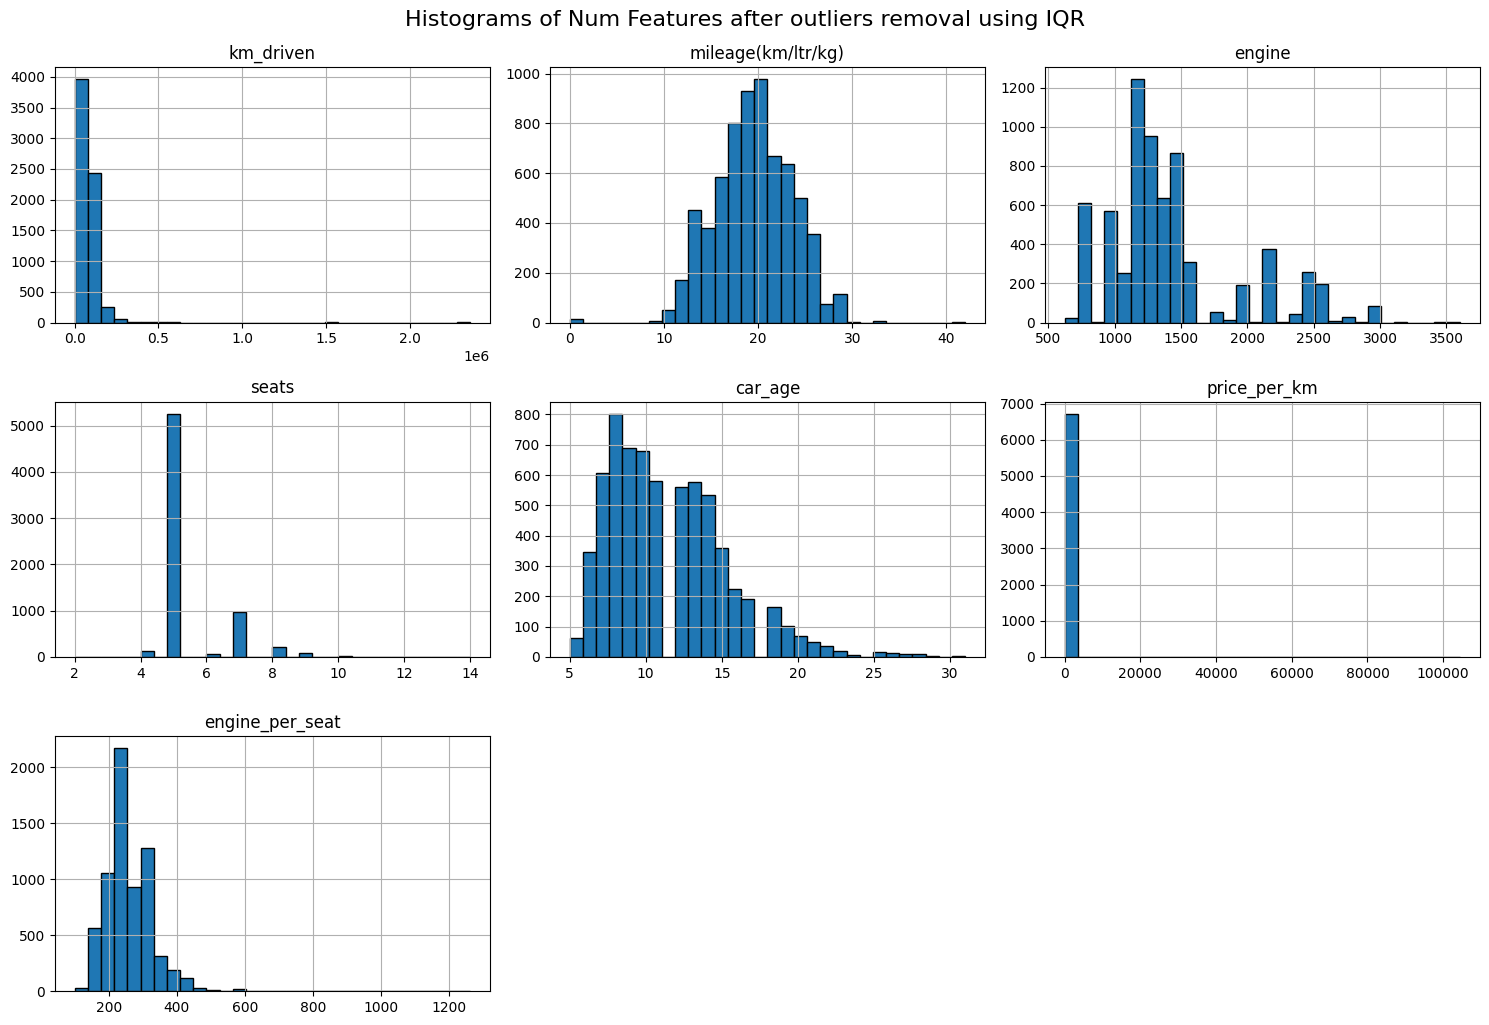

In [12]:
# Plot histogram for each numerical column
car_dataset[num_cols].hist(bins=30, figsize=(15, 10), edgecolor='black')
plt.tight_layout()
plt.suptitle('Histograms of Num Features after outliers removal using IQR', fontsize=16, y=1.02)
plt.show()

In [13]:
# Identify numeric and categorical columns from X_train
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns

# Impute numeric on X_train and transform X_val
num_imputer = SimpleImputer(strategy='mean')
X_train[num_cols] = pd.DataFrame(
    num_imputer.fit_transform(X_train[num_cols]),
    columns=num_cols,
    index=X_train.index
)
X_val[num_cols] = pd.DataFrame(
    num_imputer.transform(X_val[num_cols]),
    columns=num_cols,
    index=X_val.index
)

# Impute categorical on X_train and transform X_val
cat_imputer = SimpleImputer(strategy='most_frequent')
X_train[cat_cols] = pd.DataFrame(
    cat_imputer.fit_transform(X_train[cat_cols]),
    columns=cat_cols,
    index=X_train.index
)
X_val[cat_cols] = pd.DataFrame(
    cat_imputer.transform(X_val[cat_cols]),
    columns=cat_cols,
    index=X_val.index
)

In [14]:
X_test.isnull().sum()

km_driven             0
fuel                  0
seller_type           0
transmission          0
owner                 0
mileage(km/ltr/kg)    0
engine                0
max_power             0
seats                 0
car_age               0
price_per_km          0
engine_per_seat       0
dtype: int64

In [15]:
X_train.info()
X_val.info()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3560 entries, 2856 to 4977
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   km_driven           3560 non-null   float64
 1   fuel                3560 non-null   object 
 2   seller_type         3560 non-null   object 
 3   transmission        3560 non-null   object 
 4   owner               3560 non-null   object 
 5   mileage(km/ltr/kg)  3560 non-null   float64
 6   engine              3560 non-null   float64
 7   max_power           3560 non-null   object 
 8   seats               3560 non-null   float64
 9   car_age             3560 non-null   float64
 10  price_per_km        3560 non-null   float64
 11  engine_per_seat     3560 non-null   float64
dtypes: float64(7), object(5)
memory usage: 361.6+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 445 entries, 1671 to 2693
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
--

In [16]:
# Identify numeric and categorical columns from X_train
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns

# Preprocessing: scale numeric, one-hot encode categorical
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ])

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42)
}

# Create pipelines
pipelines = {name: Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
]) for name, model in models.items()}

# Fit and evaluate all models
best_model = None
best_score = -np.inf

for name, pipe in pipelines.items():
    print(f"Training {name}...")
    pipe.fit(X_train, y_train)
    preds_log = pipe.predict(X_val)

    # Invert log1p transform for both prediction and true labels
    true_vals = np.expm1(y_val)
    pred_vals = np.expm1(preds_log)

    # Evaluate
    mae = mean_absolute_error(true_vals, pred_vals)
    r2 = r2_score(true_vals, pred_vals)
    print(f"{name} MAE: {mae:.2f}, R2: {r2:.3f}\n")

    # Track best overall model (optional)
    if r2 > best_score:
        best_score = r2
        best_model = pipe

# -------------------------
# Now, hyperparameter tuning for XGBoost using GridSearchCV on training data

pipeline_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
])

param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.1, 0.2]
}

grid_search = GridSearchCV(pipeline_xgb, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("Best parameters found by GridSearchCV:", grid_search.best_params_)
print("Best CV R2 score:", grid_search.best_score_)

# Save the best tuned model pipeline
joblib.dump(grid_search.best_estimator_, '../model/xgboost_pipeline_tuned.pkl')
print("*Tuned XGBoost pipeline saved as 'xgboost_pipeline_tuned.pkl'*")


Training Linear Regression...
Linear Regression MAE: 54307.19, R2: 0.882

Training Random Forest...
Random Forest MAE: 15747.57, R2: 0.983

Training XGBoost...
XGBoost MAE: 13781.97, R2: 0.989

Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 931
[LightGBM] [Info] Number of data points in the train set: 3560, number of used features: 68
[LightGBM] [Info] Start training from score 12.714226
LightGBM MAE: 11593.85, R2: 0.992

Fitting 5 folds for each of 27 candidates, totalling 135 fits


e:\ML_Project\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Best parameters found by GridSearchCV: {'model__learning_rate': 0.2, 'model__max_depth': 5, 'model__n_estimators': 200}
Best CV R2 score: 0.993011243283064
*Tuned XGBoost pipeline saved as 'xgboost_pipeline_tuned.pkl'*


In [17]:
# Custom R² scorer that inverts log1p
def r2_log_inverse(y_true_log, y_pred_log):
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    return r2_score(y_true, y_pred)

# Use make_scorer to create a scorer usable in cross_val_score
r2_custom_scorer = make_scorer(r2_log_inverse, greater_is_better=True)

# Define pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

# Use cross_val_score with custom scorer
r2_scores = cross_val_score(pipeline, X, y, cv=5, scoring=r2_custom_scorer)

print("Cross-val R2 scores (actual scale):", r2_scores)
print("Mean R2:", r2_scores.mean())

Cross-val R2 scores (actual scale): [0.86389183 0.85683527 0.86873678 0.8693486  0.86777112]
Mean R2: 0.8653167203696818


In [18]:
# Load the entire pipeline (includes preprocessor + model)
pipeline = joblib.load('../model/xgboost_pipeline_tuned.pkl')

In [19]:
# Predict (still in log scale)
y_pred_log = pipeline.predict(X_test)

# Invert transformation to get actual prices
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)  # Only if y_val was log1p-transformed

# Basic evaluation metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred) * 100  # in %

# Print results
print("Model Evaluation Metrics on Test Set")
print(f"MAE  (Mean Absolute Error):        {mae:.2f}")
print(f"MSE  (Mean Squared Error):         {mse:.2f}")
print(f"RMSE (Root Mean Squared Error):    {rmse:.2f}")
print(f"R²   (R-squared):                  {r2:.4f}")
print(f"MAPE (Mean Absolute % Error):      {mape:.2f}%")


Model Evaluation Metrics on Test Set
MAE  (Mean Absolute Error):        11480.94
MSE  (Mean Squared Error):         284920425.62
RMSE (Root Mean Squared Error):    16879.59
R²   (R-squared):                  0.9933
MAPE (Mean Absolute % Error):      3.15%


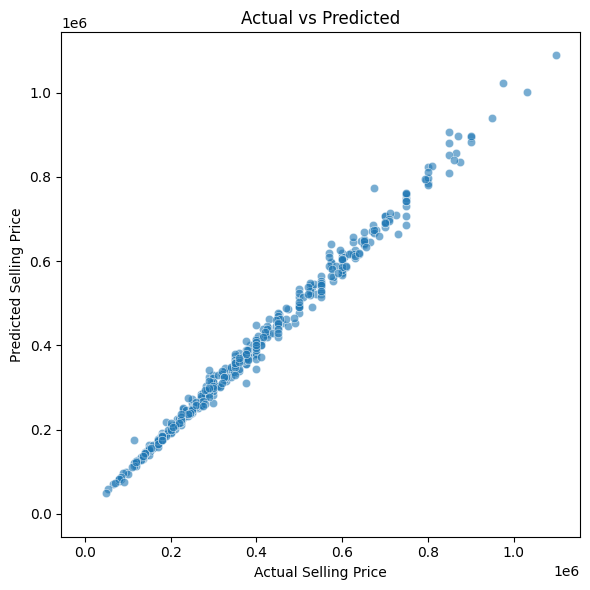

In [20]:
# Actual vs Predicted Plot
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')  # Diagonal line
plt.xlabel("Actual Selling Price")
plt.ylabel("Predicted Selling Price")
plt.title("Actual vs Predicted")
plt.tight_layout()
plt.show()

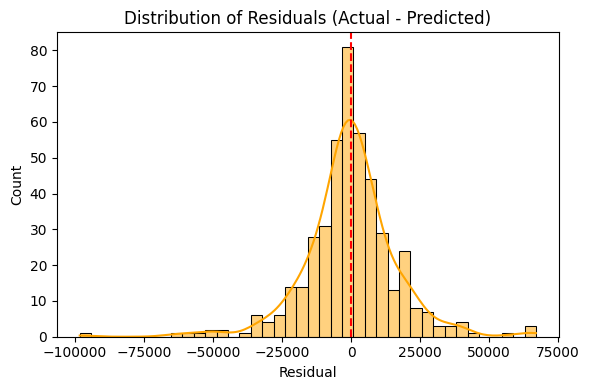

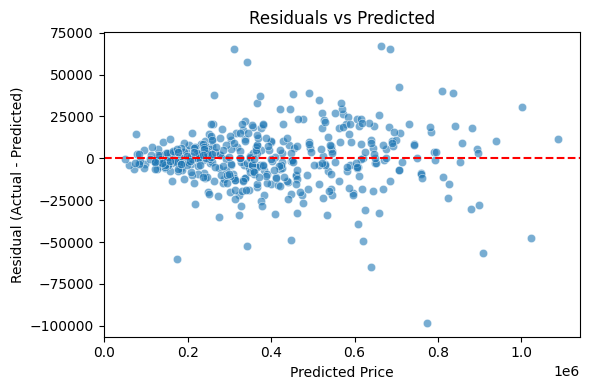

In [21]:
# Distribution of Residuals
residuals = y_true - y_pred
plt.figure(figsize=(6, 4))
sns.histplot(residuals, bins=40, kde=True, color='orange')
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribution of Residuals (Actual - Predicted)")
plt.xlabel("Residual")
plt.tight_layout()
plt.show()

# Residuals vs Predicted Plot
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Price")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals vs Predicted")
plt.tight_layout()
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_15848\2300981732.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp[:15], y=feat_imp.index[:15], palette='viridis')


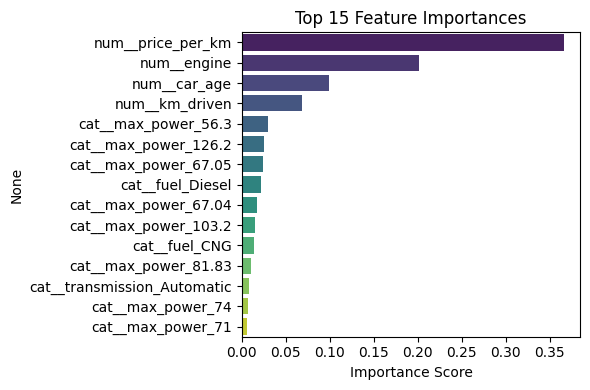

In [22]:
# Feature Importance Plot
# Extract feature importances from the XGBoost model
xgb_pipeline = joblib.load('../model/xgboost_pipeline_tuned.pkl')
importances = xgb_pipeline.named_steps['model'].feature_importances_
features = xgb_pipeline.named_steps['preprocessor'].get_feature_names_out()

feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(6, 4))
sns.barplot(x=feat_imp[:15], y=feat_imp.index[:15], palette='viridis')
plt.title("Top 15 Feature Importances")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


In [23]:
from sklearn.linear_model import ElasticNet
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ])
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', ElasticNet(max_iter=10000))
])

params = {
    'model__alpha': [0.01, 0.1, 1, 10],
    'model__l1_ratio': [0.2, 0.5, 0.8]  # Mix of L1 and L2
}

grid = GridSearchCV(pipeline, param_grid=params, scoring='r2', cv=5)
grid.fit(X_train, y_train)
grid.predict(X_val)
print("Best ElasticNet parameters:")
print(grid.best_params_)
print("Best ElasticNet R2 score:", grid.best_score_)


Best ElasticNet parameters:
{'model__alpha': 0.01, 'model__l1_ratio': 0.2}
Best ElasticNet R2 score: 0.8131877153149007


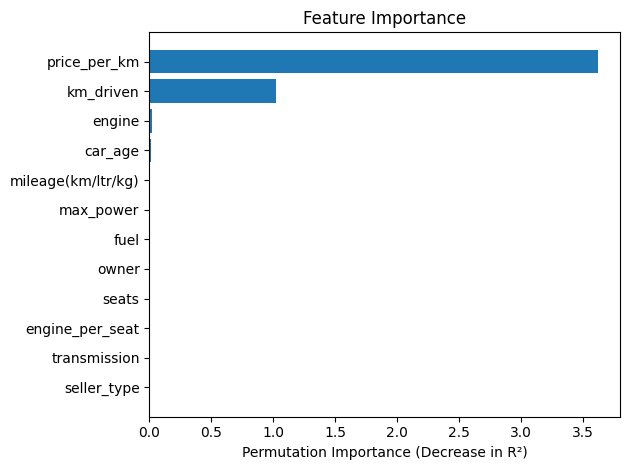

In [24]:
# Permutation Importance
# Example: assuming you have X_val, y_val, and trained model pipeline
result = permutation_importance(xgb_pipeline, X_val, y_val, n_repeats=10, random_state=42, scoring='r2')

# Visualize or print top features
import matplotlib.pyplot as plt
import numpy as np

sorted_idx = result.importances_mean.argsort()[::-1]
plt.barh(np.array(X_val.columns)[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance (Decrease in R²)")
plt.title("Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

